avail devices:
/dev/cu.wlan-debug - n/a
/dev/cu.debug-console - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbserial-DK0DLCLR - FT230X Basic UART
/dev/cu.usbserial-DK0BJ21H - FT230X Basic UART
/dev/cu.usbmodem14201 - IOUSBHostDevice
1GS00

Set jog step: 10.0 deg

1GS00

Set jog step: 10.0 deg

homed device: b'1PO00000002\r\n'


  0%|                                                    | 0/18 [00:00<?, ?it/s]

bire angle 0 deg. completion 0.0%
homed device: b'1PO00000003\r\n'



  6%|██▍                                         | 1/18 [00:20<05:43, 20.19s/it]

bire angle 10 deg. completion 5.555555555555555%
homed device: b'1PO0001180D\r\n'



 11%|████▉                                       | 2/18 [00:40<05:20, 20.06s/it]

bire angle 20 deg. completion 11.11111111111111%
homed device: b'1PO0001181B\r\n'



 17%|███████▎                                    | 3/18 [01:00<05:00, 20.02s/it]

bire angle 30 deg. completion 16.666666666666668%
homed device: b'1PO00011807\r\n'



 22%|█████████▊                                  | 4/18 [01:20<04:40, 20.00s/it]

bire angle 40 deg. completion 22.22222222222222%
homed device: b'1PO00011807\r\n'



 28%|████████████▏                               | 5/18 [01:40<04:19, 20.00s/it]

bire angle 50 deg. completion 27.77777777777778%
homed device: b'1PO00011814\r\n'



 33%|██████████████▋                             | 6/18 [02:00<03:59, 19.99s/it]

bire angle 60 deg. completion 33.333333333333336%
homed device: b'1PO00011801\r\n'



 39%|█████████████████                           | 7/18 [02:20<03:39, 19.99s/it]

bire angle 70 deg. completion 38.888888888888886%
homed device: b'1PO000117FB\r\n'



 44%|███████████████████▌                        | 8/18 [02:40<03:19, 19.99s/it]

bire angle 80 deg. completion 44.44444444444444%
homed device: b'1PO00011808\r\n'



 50%|██████████████████████                      | 9/18 [03:00<02:59, 19.99s/it]

bire angle 90 deg. completion 50.0%
homed device: b'1PO00011809\r\n'



 56%|███████████████████████▉                   | 10/18 [03:19<02:39, 19.98s/it]

bire angle 100 deg. completion 55.55555555555556%
homed device: b'1PO0001180D\r\n'



 61%|██████████████████████████▎                | 11/18 [03:39<02:19, 19.98s/it]

bire angle 110 deg. completion 61.111111111111114%
homed device: b'1PO000117F3\r\n'



 67%|████████████████████████████▋              | 12/18 [03:59<01:59, 19.98s/it]

bire angle 120 deg. completion 66.66666666666667%
homed device: b'1PO0001180C\r\n'



 72%|███████████████████████████████            | 13/18 [04:19<01:39, 19.97s/it]

bire angle 130 deg. completion 72.22222222222223%
homed device: b'1PO000117FC\r\n'



 78%|█████████████████████████████████▍         | 14/18 [04:39<01:19, 19.98s/it]

bire angle 140 deg. completion 77.77777777777777%
homed device: b'1PO00011800\r\n'



 83%|███████████████████████████████████▊       | 15/18 [04:59<00:59, 19.99s/it]

bire angle 150 deg. completion 83.33333333333333%
homed device: b'1PO00011808\r\n'



 89%|██████████████████████████████████████▏    | 16/18 [05:19<00:39, 19.98s/it]

bire angle 160 deg. completion 88.88888888888889%
homed device: b'1PO0001180B\r\n'



 94%|████████████████████████████████████████▌  | 17/18 [05:39<00:19, 19.97s/it]

bire angle 170 deg. completion 94.44444444444444%
homed device: b'1PO000117F6\r\n'



100%|███████████████████████████████████████████| 18/18 [05:59<00:00, 19.99s/it]


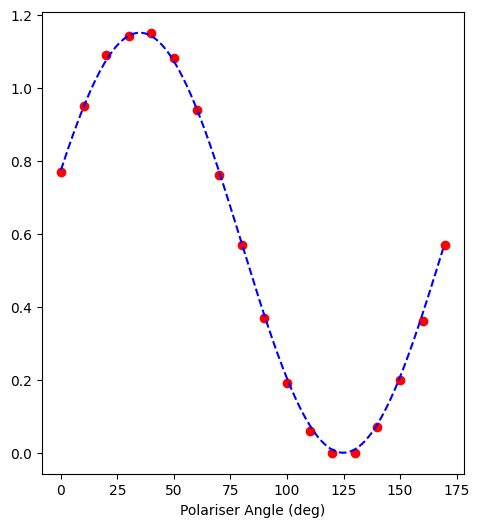

In [7]:
import numpy as np
import serial
import time
import os
import threading
from tqdm import tqdm
import serial.tools.list_ports
from scipy.optimize import curve_fit
import sys
import matplotlib.pyplot as plt

flagStop = False

# ALL INSTRUCTIONS CAN BE FOUND HERE, FROM THE MANUAL:
# https://www.thorlabs.com/Software/Elliptec/Communications_Protocol/ELLx%20modules%20protocol%20manual_Issue7.pdf

print("avail devices:")
for port in serial.tools.list_ports.comports():
    print(port)

# CONSTANTS ##########

POLARISER_DEV = "/dev/cu.usbserial-DK0DLCLR"
BIFRINGENCE_DEV = "/dev/cu.usbserial-DK0BJ21H"
ARDUINO_DEV = "/dev/cu.usbmodem14201"

######################

def MT_ExitPoll():
    while True:
        inp = input()
        if inp.strip() == 'q':
            flagStop = True
            break
    
def Degrees2Hex(deg):
    pulses = int(deg/360*143360)    # # 143360 = 360 deg
    hexPulses = hex(pulses).upper()  #  Hex characters have to be capitals
    return hexPulses[2:]

def Serial2Deg(serialString):
    pos = round((int(serialString.strip()[3:],16)/143360*360),2)
    return pos

def OpenELLDevice(device):
    dev = serial.Serial(device, baudrate=9600, stopbits=serial.STOPBITS_ONE, timeout=1)
    dev.reset_input_buffer()
    dev.flushInput()
    dev.flushOutput()
    return dev

def OpenArduinoDevice(device):
    dev = serial.Serial(device, baudrate=9600)
    dev.reset_input_buffer()
    dev.flushInput()
    dev.flushOutput()
    return dev

def ELL_SetJog(degrees, device):
    jogStepSize = str(Degrees2Hex(degrees))
    if len(jogStepSize)<4:
        jogStepSize = jogStepSize.zfill(4)
    # 1. serial instruction to set step size
    writeString = '1sj0000'+ str(jogStepSize)
    device.write((writeString).encode('utf-8'))                            
    time.sleep(0.1)
    if(device.in_waiting > 0):
        serialString = device.readline().decode('ascii')                
        print(serialString) # any messages back
    # 2. check its set
    device.write(("1gj" + "\n").encode('utf-8'))         
    time.sleep(0.1)
    if(device.in_waiting > 0):
        serialString = device.readline().decode('ascii')                   
        print('Set jog step: ' + str(round((int(serialString.strip()[3:],16)/143360*360),2)) + ' deg\n')

def ELL_ResetHome(device):
    device.reset_input_buffer()
    device.write(b'1r -50\n')
    time.sleep(0.3)
    device.write(b'1ho\n') 
    time.sleep(0.3)
    t0 = time.time()
    reply = b''
    while time.time() - t0 < 3:  # 3s timeout
        if device.in_waiting:
            reply += device.read(device.in_waiting)
            if b'PO' in reply or b'OK' in reply:
                print("homed device:", reply)
                break
        time.sleep(0.05)
    else:
        print("timeout occured while homing ELL!", reply)

def ELL_RotateSingle(device, verbose = True):
    device.write(('1fw' + '\n').encode('utf-8'))
    time.sleep(0.05) # 50 ms delay for motor
    if(device.in_waiting > 0 and verbose):
        serialString = device.readline().decode('ascii')                
        pos0 = round(Serial2Deg(serialString))
        if pos0 > 143360:
            pos0 = 0
        print('Current position of linear polariser = ' + str(pos0) + ' deg' + '\n') 

# rotate device and generate angles to power recieved readings.
def ELL_Rotate(device, ard_device, startDegree, endDegree, degreeStep, degreeStepBire, bire, onlyOne, verbose = True):
    global flagStop
    ELL_SetJog(degreeStep, device)
    ELL_SetJog(degreeStepBire, bire)
    ELL_ResetHome(bire)
    angles = np.arange(startDegree, endDegree, degreeStep)
    anglesBire = np.arange(startDegree, endDegree, degreeStepBire)
    allPowers = []
    degCur = startDegree
    times = []
    for idxBire in tqdm(anglesBire):
        print(f"bire angle {degCur} deg. completion {100 * (degCur - startDegree) / (endDegree - startDegree)}%")
        ELL_ResetHome(device)
        powerReadings = [] # from ard
        timeReadings = []
        for idx in tqdm(angles):
            
            if flagStop:
                exit(0)

            ard_device.write('pol'.encode()) # poll data
            pol = ard_device.readline().decode('ascii')
            powerReadings.append(float(pol.strip()))
            timeReadings.append(time.time_ns())
    
            # rotate command
            
            ELL_RotateSingle(device, verbose)
        ELL_RotateSingle(bire, verbose)
        allPowers.append(powerReadings)
        times.append(timeReadings)
        degCur = degCur + degreeStepBire
        if onlyOne:
            break

    return angles, allPowers, times

# plot the data from a rotation sequence. pass in the model function to plot against (must take in theta, p1, p2 and p3)
def MakePlot(ModelProc, angles, powers, saveDir):
    plt.close('all')
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(121)
    plt.plot(angles,powers[0],'ro')
    plt.xlabel('Polariser Angle (deg)')
    popt, pcov = curve_fit(ModelProc, angles, powers[0], bounds = ([-5,-5,0],[5,5,np.pi]))
    Emax, Emin, alpha = popt
    fittingAngles = np.arange(np.nanmin(angles), np.nanmax(angles),1)
    plt.plot(fittingAngles,model_f(fittingAngles, Emax, Emin, alpha),'--b')
    plt.savefig(saveDir+'/DataPlot.png')
    data_out = np.column_stack([angles] + powers)
    np.savetxt(saveDir+'/Data.csv', data_out, delimiter=',', header='angles' + ','.join([f'y_{i}' for i in range(len(powers))]))

def model_f(theta,p1,p2,p3):
  degrees = np.pi/180
  return (p1*np.cos(theta*degrees-p3))**2 + (p2*np.sin(theta*degrees-p3))**2

################################################################################################################

# perform experiment data retrieval
def AsyncRun():
    polariser = OpenELLDevice(POLARISER_DEV)
    bire = OpenELLDevice(BIFRINGENCE_DEV)
    arduino = OpenArduinoDevice(ARDUINO_DEV)

    angs, pows, _times = ELL_Rotate(polariser, arduino, 0, 180, 10, 10, bire, False, False)
    MakePlot(model_f, angs, pows, "/users/lucas/desktop/physics/year 3/dissert 1/dat/latest")

    #ELL_Rotate(polariser, arduino, 0, 360, 10)

       
# kickoff     
#bgthread = threading.Thread(target=AsyncRun)
#bgthread.start()
##MT_ExitPoll()
AsyncRun()